### Cavity Spectrum Analysis
        Sean Keenan, PhD Physics
        Quantum Memories Group, Heriot-Watt University, Edinburgh
        2021

In [6]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as mp
import scipy.signal as sp
from scipy.ndimage import gaussian_filter
import spec_funcs as sf

In [7]:
# change to gui at later date

# load requried file (.csv)
dir = 'C:\\Users\\sk88\\Desktop'
folder = 'New folder' 
file = 'ERR01.csv' 
path = dir + '\\' + folder + '\\' + file

# input known cavity constants (MHz)
FSR = 599.646
delta_nu = 285.267e-3
# scan voltage (V)
scan_volt = 9
# define threshold values
tr_peak_thresh = 0.8
noise_thresh = 0.01

# extract raw data to data frame
raw_data = pd.read_csv(path, delimiter=',', header=0)

# split data frame to components
time_base = raw_data.iloc[:,0]
scan_amp = raw_data.iloc[:,1]
transmitted = raw_data.iloc[:,3]
#reflected = raw_data.iloc[:,3]
error_sig = raw_data.iloc[:,2]

if np.amin(transmitted) < 0:
    transmitted += np.sqrt(np.amin(transmitted)**2)

#dataset = [scan_amp, transmitted, reflected]
dataset = [scan_amp, transmitted, error_sig]
#labels = ['scan amp', 'transmitted', 'reflected']
labels = ['scan amp', 'transmitted', 'error signal']
colourlist = ['yellow', 'green', 'orange']

[Text(0.5, 0, 'Timebase (s)')]

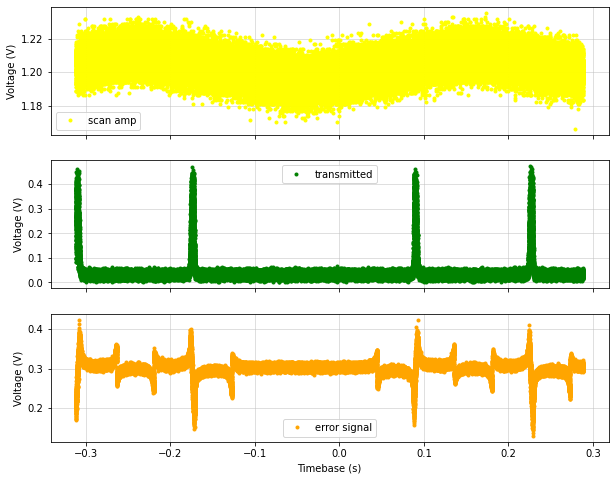

In [8]:
# plot to show spectrum
fig_1, ax_1 = mp.subplots(nrows=3, ncols=1, figsize=(10,8), sharex=True, sharey=False)

for index, axis in enumerate(ax_1):

    axis.plot(time_base, dataset[index], color=colourlist[index], marker='.', linestyle='None', label=labels[index])
    axis.set(ylabel='Voltage (V)')
    axis.grid(True)
    axis.grid(True, color='silver', linewidth=0.5)
    axis.legend(loc='best', fontsize=10)

axis.set(xlabel='Timebase (s)')

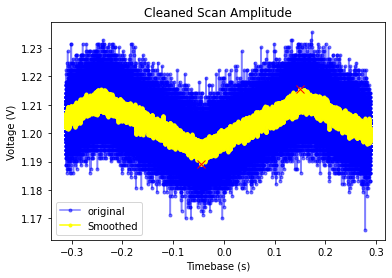

In [9]:
# find LOESS of scan amplitude
scan_smoothed = sp.savgol_filter(scan_amp, window_length=51, polyorder=3,mode='mirror')
scan_index = [np.argmin(scan_smoothed), np.argmax(scan_smoothed)]

# plot to check smoothing and piezo limit detection
fig_2, ax_2 = mp.subplots()

ax_2.plot(time_base, scan_amp, color='blue', marker='.', alpha=0.5, label='original')
ax_2.plot(time_base, scan_smoothed, color='yellow', marker='.', label='Smoothed')
ax_2.plot(time_base[scan_index[0]], scan_smoothed[scan_index[0]], 'xr', markersize=8)
ax_2.plot(time_base[scan_index[1]], scan_smoothed[scan_index[1]], 'xr', markersize=8)
ax_2.set_title('Cleaned Scan Amplitude')
ax_2.set(xlabel = 'Timebase (s)', ylabel='Voltage (V)')
ax_2.legend(loc='best')

61011.807869565215 6779.089763285024


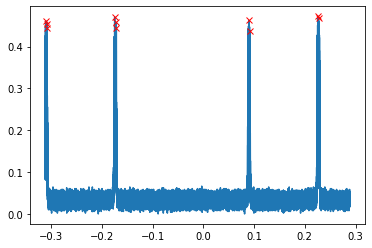

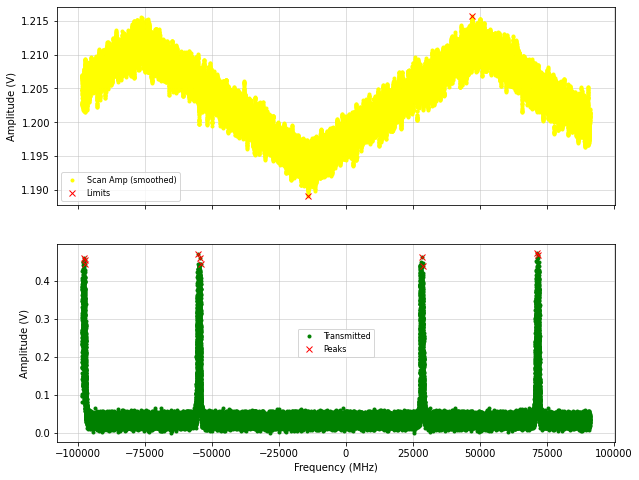

In [10]:
# find transmitted peaks and maximum peak values
tr_peak_thresh = np.amax(transmitted) * tr_peak_thresh
tr_peaks, _ = sp.find_peaks(transmitted, prominence=tr_peak_thresh)

mp.plot(time_base, transmitted)
mp.plot(time_base[tr_peaks], transmitted[tr_peaks], 'xr')

# calculate frequency step size from known FSR - change x-axis from time to frequency
tr_peak_range = []
for index in tr_peaks:
    if index > scan_index[0] and index < scan_index[1]:
        tr_peak_range.append(index)    

freq_step = ((len(tr_peak_range) - 1) * FSR) / (tr_peak_range[-1] - tr_peak_range[0])
x_scale = np.amin(np.where(time_base >= 0))
frequency = np.arange(start=-x_scale, stop=time_base.size - x_scale, step=1) * freq_step

# calculate scan frequency range
scan_freq = (freq_step * (scan_index[1] - scan_index[0]))
volt_hz = scan_freq / scan_volt
print(scan_freq, volt_hz)

# plot to show spectrum
fig_3, ax_3 = mp.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True, sharey=False)

ax_3[0].plot(frequency, scan_smoothed, color='yellow', marker='.', linestyle='None', label='Scan Amp (smoothed)')
ax_3[0].plot(frequency[scan_index[:]], scan_smoothed[scan_index[:]], color='red', marker='x', linestyle='None', label='Limits')
ax_3[1].plot(frequency, transmitted, color='green', marker='.', linestyle='None', label='Transmitted')
ax_3[1].plot(frequency[tr_peaks], transmitted[tr_peaks], color='red', marker='x', linestyle='None', label='Peaks')
ax_3[1].set(xlabel='Frequency (MHz)')

for axis in ax_3:
    axis.set(ylabel='Amplitude (V)')
    axis.legend(loc='best', fontsize=8)
    axis.grid(True, color='silver', linewidth=0.5)


In [11]:
# calculate a threshold for isolating a lorentzian
threshold = transmitted[tr_peaks] * noise_thresh
# copy peaks data
start = copy.deepcopy(tr_peaks)
stop = copy.deepcopy(tr_peaks)
# calculate approximate halfmax for lorentzian
halfmax = np.array(transmitted[tr_peaks]) * 0.5

# gaussian filter and fitting params
sig = 0.3
meth = 'trf'
# tolerance value for initial fit conditions (amp, y_0, x_0, gamma)
tolerance = [0.05, 0.5, 0.5, 0.5]
# find bounds for lorentzians (extreme edges)
lower = []
upper = []

for index, value in enumerate(threshold):
    # find lowest acceptable index for height data
    while transmitted[start[index]] > value:
        start[index] -= 1
    # find highest acceptable index for height data
    while transmitted[stop[index]] > value:
        stop[index] += 1

# smooth lorentzian data
spike = []
for index, value in enumerate(start):
    spike.append(gaussian_filter(transmitted[value:stop[index]], sigma=sig))
    # find acceptable indexes for edges of halfmax position
    top = np.where(spike[index] >= halfmax[index])
    lower.append(np.amin(top))
    upper.append(np.amax(top))

# convert to array for processing
spike = np.array(spike, dtype=object)

gamma = []
x = []
x_0 = []
height = []
amp = []
y_0 = []
fit_data = []
x_axis = []
fitted = []

# generate fits to the smoothed data
for index, value in enumerate(upper):
    
    # calculate params for fitting from smoothed data - convert to frequency 
    gamma.append((value - lower[index]) * freq_step)
    x.append(range(len(spike[index])) * freq_step + frequency[start[index]])
    x_0.append(np.argmax(spike[index]) * freq_step + frequency[start[index]])
    height.append(spike[index])
    amp.append(np.amax(spike[index]))
    y_0.append(np.average(spike[index]))

    # fitting to data
    params = [amp[index], y_0[index], x_0[index], gamma[index]]
    low_lims = []
    high_lims = []
    for index_2, value in enumerate(params):
        if value >= 0:
            low_lims.append(value * (1 - tolerance[index_2]))
            high_lims.append(value * (1 + tolerance[index_2]))
        else:
            low_lims.append(value * (1 + tolerance[index_2]))
            high_lims.append(value * (1 - tolerance[index_2]))
    
    limits = (low_lims, high_lims)
    fit_data.append(sf.fitlorentz(x[index], height[index], params, meth, limits))
    x_axis.append(frequency[start[index]:stop[index]])
    fitted.append(sf.lorentzian(x_axis[index], *fit_data[index][0]))

x_axis = np.array(x_axis, dtype=object)
fitted = np.array(fitted, dtype=object)

fig, ax = mp.subplots()
ax.plot(x_axis[0], spike[0], color='blue', marker='.', linestyle='None', label='Smoothed Data')
ax.plot(x_axis[0], transmitted[start[0]:stop[0]], color='red', marker='.', linestyle='None', alpha=0.25, label='Original Data')
ax.plot(x_axis[0], fitted[0], 'b', label='Smoothed Fit')

ax.set(xlabel='Frequency (MHz)', ylabel='Amplitude (V)')
ax.legend(loc='best', fontsize=8)
ax.legend(loc='best', fontsize=8)

ax.grid(True)
ax.grid(True, color='silver', linewidth=0.5)

print(fit_data[0][0])

KeyError: -1

In [ ]:
# plot gaussian fit to data  

# define figure and axes
fig_2, ax_2 = mp.subplots(nrows=1, ncols=len(tr_peaks), figsize=(15,8), sharex=False, sharey=True)
# plot data

for index, axis in enumerate(ax_2):
     # plot smoothed data with fit
    axis.plot(x_axis[index], spike[index], color='blue', marker='.', linestyle='None', label='Smoothed Data', alpha=0.2)
    axis.plot(x_axis[index], fitted[index], color='blue', marker='None', linestyle='-', label='Smoothed Fit')
    # plot original data
    axis.plot(x_axis[index], transmitted[start[index]:stop[index]], color='red', marker='.', linestyle='None', alpha=0.2, label='Original Data')

    # format plots
    axis.set(xlabel='Frequency (MHz)', ylabel='Amplitude (V)')
    axis.legend(loc='best', fontsize=8)
    axis.legend(loc='best', fontsize=8)
    axis.grid(True)
    axis.grid(True, color='silver', linewidth=0.5)
    print(fit_data[index])

mp.show()

In [ ]:
line = 0

for index in np.arange(len(fit_data)):
    line += fit_data[index][0][3]
    print(fit_data[index][0][3])

line_av = line/len(fit_data)
print(line_av)
print(line_av/delta_nu)
print(delta_nu)

In [ ]:
ref_av = np.average(reflected)
ref_min = np.amin(reflected)
mp.plot(time_base, reflected)
mp.axhline(ref_av, color='red')
mp.axhline(ref_min, color='red')
mp.title('Reflected Signal')
mp.xlabel('Timebase (s)')
mp.ylabel('Voltage (V)')

contrast = (ref_av - ref_min) / ref_av
print(contrast)
print(ref_min/ref_av)

In [ ]:
mp.plot(sf.lorentzian(frequency, fit_data[0][:][:]))